In [5]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt

This uses as a functional inner product for real-valued functions on the interval $[a,b]$
$$
    \langle f,g \rangle = \frac{1}{b-a}\int_a^b f(x)g(x)\mathrm dx.
$$
This is approximated by taking the mean value of $\hat f\hat g$, where $\hat f$ is a vector of the values of $f$ at uniformly-spaced points in the interval.


In [88]:
def gen_function_vals(funcs, x):
    return np.row_stack([f(x) for f in funcs])

def inner_prod(A, B):
    """Takes the approximated functional inner product of functions in A and B. Each can be either a 1-d array, or a 2-d
    array where each row corresponds to the values of a function."""
    A = np.atleast_2d(A)
    B = np.atleast_2d(B)
    if A.shape[1]!=B.shape[1]:
        raise ValueError("Shape mismatch: second dimensions of {} and {} do not match".format(A.shape,B.shape))
    n = A.shape[1]
    return np.einsum('jn,kn->jk',A,B)/n
    
def create_orthogonal_basis(A, orthonormal=True):
    w, V = la.eigh(inner_prod(A,A))
    if orthonormal:
        return V.T@A / np.sqrt(w).reshape(-1,1)
    else:
        return V.T@A

In [18]:
def print_cleaned_matr(A, tol=1e-9):
    B = A.copy()
    B[np.abs(B)<tol]=0
    print(B)

In [36]:
functions = [
    np.ones_like,
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.sin(2*x),
    lambda x: np.sin(3*x)
]
x=np.linspace(0,np.pi,150)
A = gen_function_vals(functions, x)

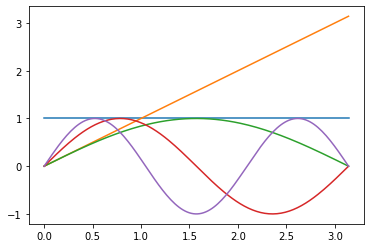

In [11]:
plt.plot(x, A.T)
plt.show()

In [41]:
#Compute inner product
S = inner_prod(A,A)
print_cleaned_matr(S)
#Find eigenvalues of inner product matrix
w, V = la.eigh(S)
print(w)
print_cleaned_matr(V)
Atilde = create_orthogonal_basis(A, True)

[[ 1.          1.57079633  0.63235221  0.          0.21072159]
 [ 1.57079633  3.30090796  0.99329653 -0.49659307  0.33100071]
 [ 0.63235221  0.99329653  0.49666667  0.          0.        ]
 [ 0.         -0.49659307  0.          0.49666667  0.        ]
 [ 0.21072159  0.33100071  0.          0.          0.49666667]]
[0.03169365 0.0951896  0.49666667 0.64235923 4.52499882]
[[ 0.68786168  0.38146078  0.         -0.4407907  -0.43247837]
 [-0.12615478 -0.45970507  0.          0.2361016  -0.84676576]
 [-0.6659779   0.53653348 -0.3161434  -0.30348892 -0.27668229]
 [-0.13473381 -0.56861617  0.         -0.80475226  0.10438514]
 [-0.22192683  0.17879148  0.94871141 -0.10113299 -0.09220009]]


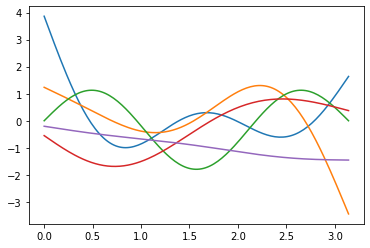

In [42]:
plt.plot(x, Atilde.T)
plt.show()

In [43]:
print_cleaned_matr(inner_prod(Atilde,Atilde))

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


# Applied to reservoir computers
Let's see if this is a useful way to analyze the homogeneity of reservoir responses!

In [44]:
import rescomp as rc
from rescomp import optimizer as rcopt

In [48]:
opt = rcopt.ResCompOptimizer('thomas','activ_f','continue','standard')

In [52]:
thomas = rcopt.get_system('thomas')
tr, Utr, ts, Uts = thomas.get_train_test_data()

In [72]:
params = {
        "res_sz": 100, #orig 1000
        "activ_f": np.tanh, #lambda x: 1/(1+np.exp(-1*x)),
        "sparse_res":True,
        "uniform_weights":True,
        "max_weight":2,
        "min_weight":0,
        "batchsize":2000,
        'sigma': 1.7525111278855319,
        'gamma': 1.7228495809159075,
        'ridge_alpha': 4.0176660163820185e-05,
        'spect_rad': 2.9385095552190155,
        'mean_degree': 3.442370236646486
    }
rescomp = rc.ResComp(**params, map_initial='activ_f')
rescomp.train(tr, Utr)
pre, states = rescomp.predict(ts, r0=rescomp.r0, return_states=True)
t = ts[:1500]
A = states.T[:,:1500]

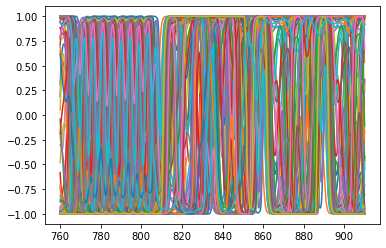

In [73]:
plt.plot(t, A.T)
plt.show()

In [74]:
Atilde = create_orthogonal_basis(A, False)

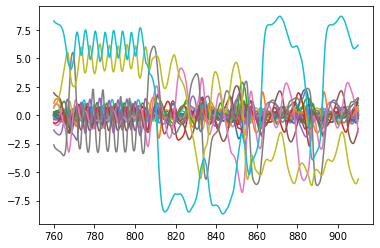

In [75]:
plt.plot(t, Atilde.T)
plt.show()

In [82]:
#Find the norm of each of these functions
norms = np.sqrt(np.mean(Atilde**2,axis=1))
print(norms)
AtildeN = Atilde/norms.reshape(-1,1)

[2.27798293e-03 2.59958777e-03 3.45299890e-03 3.78175786e-03
 4.51290738e-03 5.23445990e-03 5.27926391e-03 6.06084094e-03
 6.68501277e-03 7.33638126e-03 7.51445695e-03 7.72902747e-03
 8.38305299e-03 9.07089697e-03 9.23085737e-03 1.01066169e-02
 1.06053941e-02 1.13508496e-02 1.27556059e-02 1.28426934e-02
 1.34038060e-02 1.39146063e-02 1.41741099e-02 1.55817888e-02
 1.58870019e-02 1.67283589e-02 1.74404621e-02 1.82067854e-02
 2.00150538e-02 2.02734011e-02 2.10677669e-02 2.17389902e-02
 2.28652465e-02 2.38068204e-02 2.41961496e-02 2.53286237e-02
 2.61683835e-02 2.78289094e-02 2.95270068e-02 3.14066112e-02
 3.37059607e-02 3.52243396e-02 3.65161034e-02 3.85045617e-02
 3.95547688e-02 4.33380747e-02 4.48001330e-02 4.64882877e-02
 4.84672960e-02 5.07077586e-02 5.21122603e-02 5.30388603e-02
 5.60779270e-02 5.97865614e-02 6.21267987e-02 6.58795679e-02
 6.82744985e-02 7.06091267e-02 7.18995557e-02 8.18855617e-02
 8.30969169e-02 8.74154468e-02 8.84440796e-02 9.68107165e-02
 9.78239329e-02 1.015014

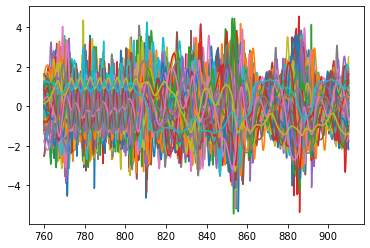

In [83]:
plt.plot(t, AtildeN.T)
plt.show()

Here, we project the true solution onto the basis functions. It's pretty spiky, as can be seen. 
Note that this is not equivalent to the prediction method of the reservoir; that uses $W_\text{out}$, computed during training, to project the reservoir signals onto signal space.

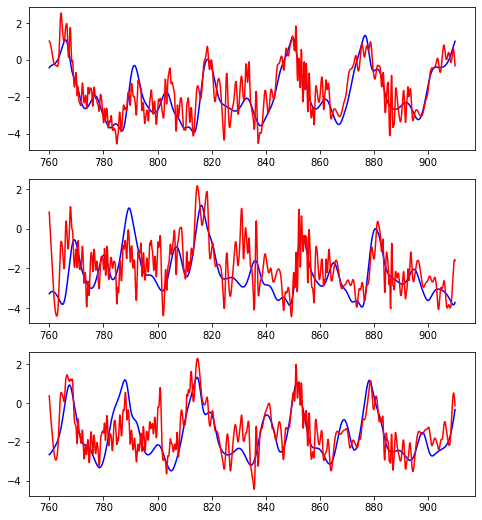

In [98]:
#Project the things
coefs = inner_prod(Uts.T[:,:1500], AtildeN)
projections = coefs@AtildeN
plt.figure(figsize=(8,9))
for j in range(3):
    plt.subplot(3,1,1+j)
    plt.plot(t, Uts[:1500,j], 'b-')
    plt.plot(t,projections[j], 'r-')
plt.show()

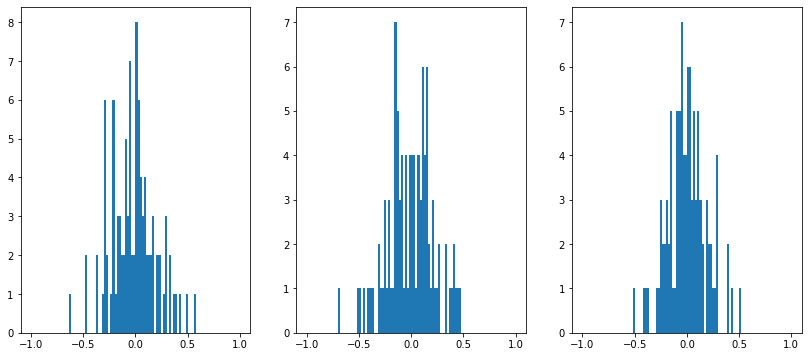

In [111]:
#Plot coefficients of orthonormal basis of projection of orig. function
plt.figure(figsize=(14,6))
bins = np.linspace(-1,1,101)
plt.subplot(1,3,1)
plt.hist(coefs[0], bins=bins)
plt.subplot(1,3,2)
plt.hist(coefs[1], bins=bins)
plt.subplot(1,3,3)
plt.hist(coefs[2], bins=bins)
plt.show()

In [106]:
func_coeffs = inner_prod(AtildeN,states.T[:,:1500])
W_out_tilde = func_coeffs @ rescomp.W_out.T

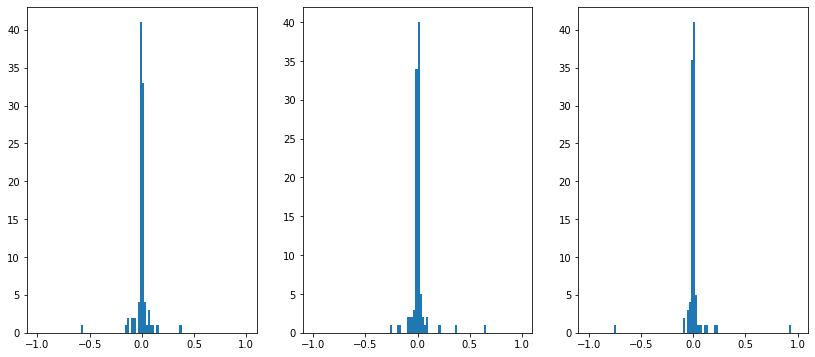

In [108]:
#Plot coefficients of W_out for each orthonormal basis function
plt.figure(figsize=(14,6))
bins = np.linspace(-1,1,101)
plt.subplot(1,3,1)
plt.hist(W_out_tilde[:,0], bins=bins)
plt.subplot(1,3,2)
plt.hist(W_out_tilde[:,1], bins=bins)
plt.subplot(1,3,3)
plt.hist(W_out_tilde[:,2], bins=bins)
plt.show()

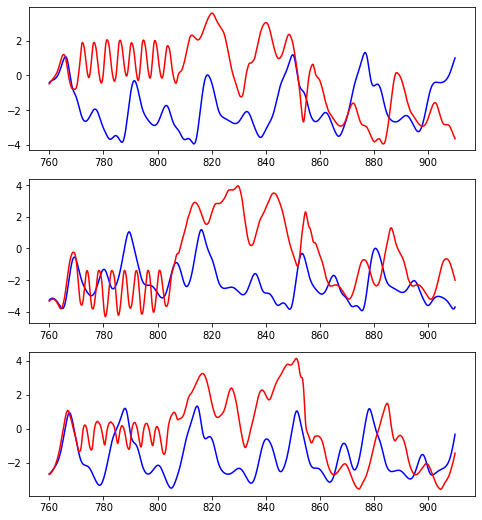

In [109]:
#Show the actual prediction
plt.figure(figsize=(8,9))
for j in range(3):
    plt.subplot(3,1,1+j)
    plt.plot(t, Uts[:1500,j], 'b-')
    plt.plot(t,pre[:1500,j], 'r-')
plt.show()